##  import libraries

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

## initial functions

In [2]:
# function to convert age into age bin
def age_bin(age):
    ab = []
    for a in age:
        if int(a) <= 25:
            ab.append(0)
        elif 25 < int(a) <= 34:
            ab.append(1)
        elif 34 < int(a) <= 48:
            ab.append(2)
        else:
            ab.append(3)
    return np.array(ab)

# function to read data from file and select gender
def read_data(data_path, selected_gender):
    print('selected gender: ', selected_gender)
    f = open(data_path, "r")
    wav_id = []
    xvector = []
    for x in f:
        wav_id.append(x.split(' ')[0])
        xvector.append([float(i) for i in x.split(' ')[3:-1]])

    actor_id, gender, age = read_actor_profile()
#     print(len(list(set(actor_id))))
    wav_age = []
    wav_actor = []
    wav, g, xvec = [], [], []

    for i in range(len(wav_id)):
        index = actor_id.index(wav_id[i][:4])
        if selected_gender == None:
            wav_actor.append(actor_id[index])
            wav_age.append(int(age[index]))
            wav = wav_id
            g = gender
            xvec = xvector
        elif selected_gender != None and gender[index] == selected_gender:
            wav_actor.append(actor_id[index])
            wav_age.append(int(age[index]))
            wav.append(wav_id[i])
            xvec.append(xvector[i])
            g.append(gender[index])

    age = age_bin(wav_age)

    return np.array(wav), np.array(wav_actor), np.array(age), np.array(xvec), g

# function to read actor profile from VideoDemographics.csv
def read_actor_profile():
    f = open("VideoDemographics.csv", "r")
    actor_id = []
    gender = []
    age = []
    for x in f:
        if "ActorID" not in x:
            actor_id.append(x.split(",")[0])
            g = x.split(",")[2].replace('"', '')
            gender.append(g)
            a = x.split(",")[1].replace('"', '')
            age.append(a)
    return actor_id, gender, age

# function to generate batch using in model
def batch_generator(x, y, batch_size, bin_no):
    df = pd.DataFrame(y)
    s = batch_size // bin_no
    while True:
        index = []
        for i in range(0, bin_no):
            if index == []:
                index = np.array(df.loc[df[0] == i].sample(s, replace=True).index)
            else:
                index = np.concatenate((index,
                    np.array(df.loc[df[0] == i].sample(s, replace=True).index)
                    ))

        x_train = [x[i] for i in index]
        y_train = [y[i] for i in index]
        combine = list(zip(x_train, y_train))
        random.shuffle(combine)
        x_train[:], y_train[:] = zip(*combine)
        yield np.array(x_train), np.array(to_categorical(y_train)).astype(np.int)

# function to plot confusion matrix (true, pred)
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    fontsize=15,
                    color= "black")
    fig.tight_layout()
    return cm

## read data

In [3]:
# select gender hear ['Male', 'Female']
select_gender = 'Female'

labels = ['<=25', '<25 <=34', '<34 <=48', '>48']
bin_no = len(labels)

# read features from file
wav_id, actor, age_bin, xvector, gender = read_data('xvector_data.txt', select_gender)
print(len(list(set(actor))))

selected gender:  Female
43


In [4]:
# select validation and test actor
train_actor = list(set(actor))
print(len(train_actor))

if select_gender == 'Male':
    val_actor = ['1038', '1086', '1083', '1034']
    test_actor = ['1022', '1031', '1041', '1087']
else:
    val_actor = ['1073', '1029', '1084', '1006']
    test_actor = ['1082', '1072', '1025', '1024']

train_actor = [i for i in train_actor if i not in val_actor]
print(len(train_actor))
train_actor = [i for i in train_actor if i not in test_actor]
print(len(train_actor))

# find train validate and test index from actor_id
train_index, val_index, test_index = [], [], []
for i in range(len(wav_id)):
    if actor[i] in train_actor:
        train_index.append(i)
    elif actor[i] in val_actor:
        val_index.append(i)
    elif actor[i] in test_actor:
        test_index.append(i)

43
39
35


In [5]:
# split data into train, validate and test set
x_train, y_train = xvector[train_index], age_bin[train_index]
x_val, y_val =  xvector[val_index], age_bin[val_index]
x_test, y_test =  xvector[test_index], age_bin[test_index]

## model

In [6]:
# MODEL
bs = 512
model = Sequential()
model.add(Dense(bs, input_dim=512))
model.add(Dropout(0.2))
model.add(Dense(bin_no , activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 264,708
Trainable params: 264,708
Non-trainable params: 0
_________________________________________________________________


In [7]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# generate batch for train and validate
train_gen = batch_generator(x_train, y_train, bs, bin_no)
val_gen = batch_generator(x_val, y_val, bs, bin_no)

callbacks = [EarlyStopping(monitor='val_loss', patience=8)]

# train model
train = model.fit_generator(
            generator=train_gen
            , epochs=500
            , steps_per_epoch=x_train.shape[0] // bs
            , validation_data=val_gen
            , validation_steps= int(x_val.shape[0] // bs) if int(x_val.shape[0] // bs)>0 else 1
            , callbacks=callbacks
            )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 1 steps
Epoch 1/500


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1/5 [=====>........................] - ETA: 2s - loss: 2.4399 - accuracy: 0.2383

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


5/5 [==============================] - 1s 172ms/step - loss: 5.1653 - accuracy: 0.2605 - val_loss: 4.3024 - val_accuracy: 0.2363
Epoch 2/500
5/5 [==============================] - 0s 22ms/step - loss: 3.7625 - accuracy: 0.2555 - val_loss: 1.5934 - val_accuracy: 0.3281
Epoch 3/500
5/5 [==============================] - 0s 27ms/step - loss: 2.5888 - accuracy: 0.2652 - val_loss: 2.7230 - val_accuracy: 0.2129
Epoch 4/500
5/5 [==============================] - 0s 28ms/step - loss: 2.2480 - accuracy: 0.2801 - val_loss: 2.2544 - val_accuracy: 0.2500
Epoch 5/500
5/5 [==============================] - 0s 22ms/step - loss: 1.9453 - accuracy: 0.2820 - val_loss: 1.9626 - val_accuracy: 0.2500
Epoch 6/500
5/5 [==============================] - 0s 18ms/step - loss: 1.7604 - accuracy: 0.2937 - val_loss: 1.6474 - val_accuracy: 0.2793
Epoch 7/500
5/5 [==============================] - 0s 16ms/step - loss: 1.5999 - accuracy: 0.3109 - val_loss: 1.5793 - val_accuracy: 0.1738
Epoch 8/500
5/5 [==============

## evaluate

In [9]:
# Evaluate model
test_loss, test_acc = model.evaluate(x_test, to_categorical(y_test))
print('Test loss:', test_loss)
print('Test accuracy(WA):', test_acc)

328/328 [==============================] - 0s 273us/sample - loss: 1.3364 - accuracy: 0.3780
Test loss: 1.3363930394009846
Test accuracy(WA): 0.37804878


In [10]:
# predict test set data
predict = model.predict(x_test)
label_predict = np.argmax(predict, axis=1)

Normalized confusion matrix
[[0.4  0.34 0.05 0.21]
 [0.3  0.39 0.12 0.18]
 [0.16 0.33 0.35 0.16]
 [0.1  0.21 0.33 0.37]]
unweighted accuracy(UA):  0.37750000000000006


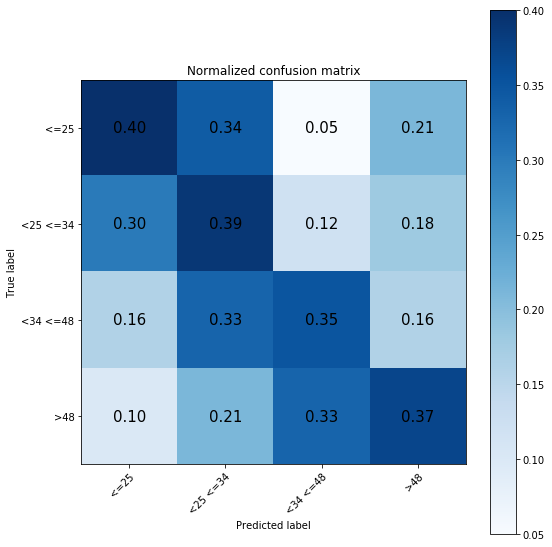

In [11]:
# plot confution metrix
cmp = plot_confusion_matrix(np.array(y_test),
                                    np.array(label_predict),
                                    classes=labels,
                                    normalize=True,
                                    title='Normalized confusion matrix')

# calculate unweighted accuracy
ua_sum = 0
for i in range(0, bin_no):
    ua_sum += cmp[i][i] 
ua = ua_sum / bin_no
print("unweighted accuracy(UA): ", ua)